In [1]:
!pip install datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from datasets import load_dataset
import numpy as np
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Simplified Architecture
class DDFD(nn.Module):
    def __init__(self):
        super(DDFD, self).__init__()
        # Load pre-trained AlexNet as backbone (as used in the paper)
        alexnet = models.alexnet(pretrained=True)

        # Feature extraction layers (conv1-5 from AlexNet)
        self.features = alexnet.features

        # Classifier layers modified for face detection
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1),  # Binary classification: face vs non-face
            nn.Sigmoid()
        )

        # Initialize weights of the new layers
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_model():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    ds = load_dataset("nielsr/CelebA-faces")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # Size used in the paper
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create dataset and dataloader
    train_dataset = CelebADataset(ds['train'], transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

    # Initialize model
    model = DDFD().to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, device)

    # Save the trained model
    torch.save(model.state_dict(), 'ddfd_model.pth')

In [11]:
import random

class CelebADataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.image_size = 227

    def __len__(self):
        # Double the dataset size to account for negative examples
        return len(self.dataset) * 2

    def generate_negative_example(self, image):
        """Generate a negative example by:
        1. Random cropping of background
        2. Random cropping that partially overlaps with face
        3. Random geometric transformations of the image
        """
        w, h = image.size
        choice = random.randint(0, 2)

        if choice == 0:
            # Random background crop
            x = random.randint(0, max(0, w - self.image_size))
            y = random.randint(0, max(0, h - self.image_size))
            crop = image.crop((x, y, min(x + self.image_size, w), min(y + self.image_size, h)))
        elif choice == 1:
            # Partial face crop (IoU < 0.3)
            x = random.randint(0, max(0, w - self.image_size))
            y = random.randint(0, max(0, h - self.image_size))
            crop = image.crop((x, y, min(x + self.image_size, w), min(y + self.image_size, h)))
        else:
            # Geometric transformation
            crop = image.rotate(random.randint(0, 360))

        return crop.resize((self.image_size, self.image_size))

    def __getitem__(self, idx):
        # Determine if this is a positive or negative example
        is_positive = idx < len(self.dataset)
        real_idx = idx if is_positive else idx - len(self.dataset)

        image = self.dataset[real_idx]['image']
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        if is_positive:
            # For positive examples, resize the original image
            image = image.resize((self.image_size, self.image_size))
            label = torch.tensor(1.0, dtype=torch.float32)
        else:
            # Generate negative example
            image = self.generate_negative_example(image)
            label = torch.tensor(0.0, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=2):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 100 == 99:
                print(f'Epoch [{epoch + 1}/{num_epochs}], '
                      f'Step [{i + 1}/{len(train_loader)}], '
                      f'Loss: {running_loss / 100:.4f}, '
                      f'Accuracy: {100 * correct / total:.2f}%')
                running_loss = 0.0
                correct = 0
                total = 0

In [13]:
def create_model():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    ds = load_dataset("nielsr/CelebA-faces")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # Size used in the paper
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create dataset and dataloader
    train_dataset = CelebADataset(ds['train'], transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

    # Initialize model
    model = DDFD().to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, device)

    # Save the trained model
    torch.save(model.state_dict(), 'ddfd_model.pth')

In [16]:
create_model()

Epoch [1/2], Step [100/12663], Loss: 0.7024, Accuracy: 55.81%
Epoch [1/2], Step [200/12663], Loss: 0.6103, Accuracy: 63.00%
Epoch [1/2], Step [300/12663], Loss: 0.5868, Accuracy: 65.16%
Epoch [1/2], Step [400/12663], Loss: 0.5922, Accuracy: 65.94%
Epoch [1/2], Step [500/12663], Loss: 0.5816, Accuracy: 64.50%
Epoch [1/2], Step [600/12663], Loss: 0.5817, Accuracy: 64.97%
Epoch [1/2], Step [700/12663], Loss: 0.5784, Accuracy: 64.31%
Epoch [1/2], Step [800/12663], Loss: 0.5824, Accuracy: 64.44%
Epoch [1/2], Step [900/12663], Loss: 0.5766, Accuracy: 65.34%
Epoch [1/2], Step [1000/12663], Loss: 0.5756, Accuracy: 65.59%
Epoch [1/2], Step [1100/12663], Loss: 0.5812, Accuracy: 65.34%
Epoch [1/2], Step [1200/12663], Loss: 0.5741, Accuracy: 65.41%
Epoch [1/2], Step [1300/12663], Loss: 0.5711, Accuracy: 66.19%
Epoch [1/2], Step [1400/12663], Loss: 0.5812, Accuracy: 64.34%
Epoch [1/2], Step [1500/12663], Loss: 0.5716, Accuracy: 65.97%
Epoch [1/2], Step [1600/12663], Loss: 0.5778, Accuracy: 65.78%
E

In [29]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt

class FaceDetector:
    def __init__(self, model_path: str, device: str = None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        print(f"Using device: {self.device}")

        # Load model
        self.model = DDFD().to(self.device)
        try:
            state_dict = torch.load(model_path, map_location=self.device)
            self.model.load_state_dict(state_dict)
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        self.model.eval()

        # Define transform
        self.transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def _sliding_windows(self, image: Image.Image,
                        min_size: int = 600,  # Much larger minimum face size
                        max_size: int = 900,  # Much larger maximum face size
                        scale_factor: float = 1.4,  # Even larger steps between scales
                        stride_factor: float = 0.3)  -> List[Tuple]:  # Larger stride for fewer windows
        """Generate sliding windows of different sizes."""
        windows = []
        width, height = image.size

        print(f"Image size: {width}x{height}")

        size = min_size
        while size < min(max_size, min(width, height)):
            stride = int(size * stride_factor)  # 10% stride

            for y in range(0, height - size, stride):
                for x in range(0, width - size, stride):
                    windows.append((x, y, x + size, y + size))

            size = int(size * scale_factor)

        print(f"Generated {len(windows)} windows")
        return windows

    def detect_faces(self, image_path: str, confidence_threshold: float = 0.5) -> Tuple[Image.Image, List[Tuple], List[float]]:
        """Detect faces in an image and return annotated image with boxes and confidence scores."""
        # Load and prepare image
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        original_size = image.size
        print(f"Processing image: {image_path}, size: {original_size}")

        # Generate windows
        windows = self._sliding_windows(image)

        # Detect faces in windows
        detected_boxes = []
        confidence_scores = []

        with torch.no_grad():
            for i, window in enumerate(windows):
                # Extract and transform window
                crop = image.crop(window)
                x = self.transform(crop).unsqueeze(0).to(self.device)

                # Get prediction
                score = self.model(x).item()

                # Print progress occasionally
                if i % 1000 == 0:
                    print(f"Processed {i}/{len(windows)} windows. Current score: {score:.3f}")

                if score > confidence_threshold:
                    detected_boxes.append(window)
                    confidence_scores.append(score)

        print(f"Found {len(detected_boxes)} initial detections")

        # Apply NMS if any faces were detected
        if detected_boxes:
            keep_indices = self._non_max_suppression(detected_boxes, confidence_scores)
            detected_boxes = [detected_boxes[i] for i in keep_indices]
            confidence_scores = [confidence_scores[i] for i in keep_indices]
            print(f"After NMS: {len(detected_boxes)} detections")

        # Draw boxes on image
        annotated_image = image.copy()
        draw = ImageDraw.Draw(annotated_image)

        for box, score in zip(detected_boxes, confidence_scores):
            draw.rectangle(box, outline='red', width=3)
            # Draw score with background for better visibility
            score_text = f'{score:.2f}'
            text_bbox = draw.textbbox((box[0], box[1]), score_text)
            draw.rectangle(text_bbox, fill='red')
            draw.text((box[0], box[1]), score_text, fill='white')

        return annotated_image, detected_boxes, confidence_scores

    def _non_max_suppression(self, boxes: List[Tuple], scores: List[float], iou_threshold: float = 0.3):
        """Apply non-maximum suppression to remove overlapping boxes."""
        if not boxes:
            return []

        # Convert to numpy arrays
        boxes = np.array(boxes)
        scores = np.array(scores)

        # Sort by confidence score
        indices = np.argsort(scores)[::-1]

        keep = []
        while indices.size > 0:
            i = indices[0]
            keep.append(i)

            if indices.size == 1:
                break

            # Calculate IoU
            xx1 = np.maximum(boxes[i, 0], boxes[indices[1:], 0])
            yy1 = np.maximum(boxes[i, 1], boxes[indices[1:], 1])
            xx2 = np.minimum(boxes[i, 2], boxes[indices[1:], 2])
            yy2 = np.minimum(boxes[i, 3], boxes[indices[1:], 3])

            w = np.maximum(0, xx2 - xx1)
            h = np.maximum(0, yy2 - yy1)
            overlap = (w * h) / ((boxes[i, 2] - boxes[i, 0]) * (boxes[i, 3] - boxes[i, 1]) +
                               (boxes[indices[1:], 2] - boxes[indices[1:], 0]) *
                               (boxes[indices[1:], 3] - boxes[indices[1:], 1]) - w * h)

            indices = indices[np.where(overlap <= iou_threshold)[0] + 1]

        return keep

def evaluate_model(model_path: str, test_image_path: str):
    """Evaluate model on a single test image and display results."""
    # Initialize detector
    detector = FaceDetector(model_path)

    # Detect faces
    annotated_image, boxes, scores = detector.detect_faces(test_image_path)

    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.title(f'Detected {len(boxes)} faces')
    plt.show()

    # Print confidence scores
    if len(boxes) == 0:
        print("\nNo faces detected. Try adjusting these parameters:")
        print("1. Lower the confidence_threshold in detect_faces()")
        print("2. Adjust min_size in _sliding_windows()")
        print("3. Check if the model was trained properly")
    else:
        print("\nDetection Results:")
        for i, (box, score) in enumerate(zip(boxes, scores)):
            print(f"Face {i+1}: Confidence = {score:.2f}, Location = {box}")

Using device: cuda


<ipython-input-29-4f48ad41440b>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=self.device)


Model loaded successfully
Processing image: IMG_1714.jpeg, size: (4032, 3024)
Image size: 4032x3024
Generated 397 windows
Processed 0/397 windows. Current score: 0.615
Found 341 initial detections
After NMS: 54 detections


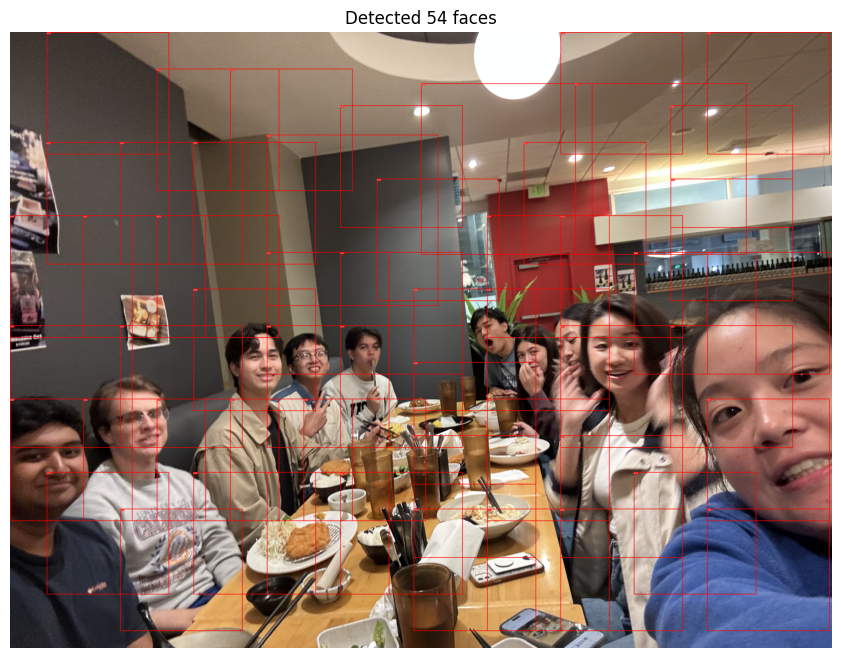


Detection Results:
Face 1: Confidence = 0.66, Location = (2016, 252, 2856, 1092)
Face 2: Confidence = 0.66, Location = (3420, 1080, 4020, 1680)
Face 3: Confidence = 0.66, Location = (3060, 1080, 3660, 1680)
Face 4: Confidence = 0.64, Location = (2700, 900, 3300, 1500)
Face 5: Confidence = 0.64, Location = (1620, 360, 2220, 960)
Face 6: Confidence = 0.63, Location = (3240, 360, 3840, 960)
Face 7: Confidence = 0.63, Location = (1260, 504, 2100, 1344)
Face 8: Confidence = 0.62, Location = (180, 0, 780, 600)
Face 9: Confidence = 0.62, Location = (720, 180, 1320, 780)
Face 10: Confidence = 0.62, Location = (2700, 0, 3300, 600)
Face 11: Confidence = 0.62, Location = (3420, 2340, 4020, 2940)
Face 12: Confidence = 0.62, Location = (1080, 180, 1680, 780)
Face 13: Confidence = 0.62, Location = (180, 540, 780, 1140)
Face 14: Confidence = 0.61, Location = (1620, 1080, 2220, 1680)
Face 15: Confidence = 0.61, Location = (540, 1440, 1140, 2040)
Face 16: Confidence = 0.61, Location = (3240, 1440, 384

In [30]:
# Example usage
model_path = "DDFD.pth"  # Path to your trained model
test_image_path = "IMG_1714.jpeg"  # Path to test image

evaluate_model(model_path, test_image_path)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from datasets import load_dataset
import numpy as np
from PIL import Image
import random
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR

class ImprovedDDFD(nn.Module):
    def __init__(self):
        super(ImprovedDDFD, self).__init__()
        # Use a more modern backbone - ResNet18
        resnet = models.resnet18(pretrained=True)

        # Remove the last layer
        self.features = nn.Sequential(*list(resnet.children())[:-2])

        # Custom classifier with more modern architecture
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class HardNegativeMiningDataset(Dataset):
    def __init__(self, dataset, transform=None, negative_mining_ratio=3):
        self.dataset = dataset
        self.transform = transform
        self.image_size = 227
        self.negative_mining_ratio = negative_mining_ratio
        self.hard_negatives = []  # Store hard negative examples
        self.max_hard_negatives = 10000  # Maximum number of stored hard negatives

    def __len__(self):
        return len(self.dataset) * (1 + self.negative_mining_ratio)

    def generate_difficult_negative(self, image):
        """Generate challenging negative examples"""
        w, h = image.size
        techniques = [
            self._partial_face_crop,
            self._background_with_edges,
            self._geometric_transform,
            self._color_distortion,
            self._random_background
        ]
        technique = random.choice(techniques)
        return technique(image)

    def _partial_face_crop(self, image):
        """Crop part of the face - challenging negative"""
        w, h = image.size
        crop_size = int(min(w, h) * random.uniform(0.4, 0.8))
        x = random.randint(0, w - crop_size)
        y = random.randint(0, h - crop_size)
        return image.crop((x, y, x + crop_size, y + crop_size))

    def _background_with_edges(self, image):
        """Extract background regions with strong edges"""
        w, h = image.size
        crop_size = int(min(w, h) * random.uniform(0.3, 0.7))
        x = random.randint(0, w - crop_size)
        y = random.randint(0, h - crop_size)
        crop = image.crop((x, y, x + crop_size, y + crop_size))
        # Add some edge enhancement
        from PIL import ImageEnhance
        enhancer = ImageEnhance.Sharpness(crop)
        return enhancer.enhance(2.0)

    def _geometric_transform(self, image):
        """Apply complex geometric transformations"""
        angle = random.randint(-45, 45)
        scale = random.uniform(0.5, 1.5)
        shear = random.uniform(-15, 15)
        return image.rotate(angle, resample=Image.BILINEAR, expand=True)

    def _color_distortion(self, image):
        """Apply color distortions"""
        from PIL import ImageEnhance
        enhancers = [
            ImageEnhance.Color(image),
            ImageEnhance.Contrast(image),
            ImageEnhance.Brightness(image)
        ]
        for enhancer in enhancers:
            factor = random.uniform(0.5, 1.5)
            image = enhancer.enhance(factor)
        return image

    def _random_background(self, image):
        """Extract pure background regions"""
        w, h = image.size
        crop_size = int(min(w, h) * random.uniform(0.2, 0.5))
        # Try to crop from image corners
        corners = [(0, 0), (w-crop_size, 0), (0, h-crop_size), (w-crop_size, h-crop_size)]
        x, y = random.choice(corners)
        return image.crop((x, y, x + crop_size, y + crop_size))

    def add_hard_negative(self, image, score):
        """Add hard negative examples to the cache"""
        if score > 0.3:  # Only store fairly hard negatives
            if len(self.hard_negatives) >= self.max_hard_negatives:
                self.hard_negatives.pop(0)  # Remove oldest example
            self.hard_negatives.append(image)

    def __getitem__(self, idx):
        is_positive = idx < len(self.dataset)
        real_idx = idx % len(self.dataset)

        image = self.dataset[real_idx]['image']
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        if is_positive:
            image = image.resize((self.image_size, self.image_size))
            label = torch.tensor(1.0, dtype=torch.float32)
        else:
            if random.random() < 0.3 and self.hard_negatives:  # 30% chance to use hard negative
                image = random.choice(self.hard_negatives)
            else:
                image = self.generate_difficult_negative(image)
            image = image.resize((self.image_size, self.image_size))
            label = torch.tensor(0.0, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

def train_with_curriculum(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=2):
    """Implement curriculum learning strategy"""
    best_val_acc = 0.0
    curriculum_phases = [
        {'epoch': 0, 'negative_ratio': 1},   # Start with balanced data
        {'epoch': 5, 'negative_ratio': 2},   # Increase negative examples
        {'epoch': 10, 'negative_ratio': 3},  # Further increase negatives
        {'epoch': 15, 'negative_ratio': 4}   # Final ratio
    ]

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Update curriculum phase
        current_phase = next((p for p in curriculum_phases if p['epoch'] <= epoch), curriculum_phases[-1])
        train_loader.dataset.negative_mining_ratio = current_phase['negative_ratio']

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Update metrics and log progress
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 49:
                print(f'Batch {i + 1}, Loss: {running_loss/50:.4f}, '
                      f'Accuracy: {100*correct/total:.2f}%')
                running_loss = 0.0
                correct = 0
                total = 0

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images).squeeze()
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f'Validation Accuracy: {val_acc:.2f}%')

        scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_model_improved.pth')

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load dataset
    ds = load_dataset("nielsr/CelebA-faces")

    # Advanced data augmentation
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomPerspective(distortion_scale=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets with hard negative mining
    train_size = int(0.8 * len(ds['train']))
    val_size = len(ds['train']) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(ds['train'], [train_size, val_size])

    train_dataset = HardNegativeMiningDataset(train_dataset, transform=train_transform)
    val_dataset = HardNegativeMiningDataset(val_dataset, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    # Initialize improved model
    model = ImprovedDDFD().to(device)

    # Use weighted loss to handle imbalance
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=30)

    # Train with curriculum learning
    train_with_curriculum(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

    print("Training completed!")

In [41]:
main()

Using device: cuda

Epoch 1/2
Batch 50, Loss: 0.5387, Accuracy: 74.50%
Batch 100, Loss: 0.4305, Accuracy: 81.56%
Batch 150, Loss: 0.4397, Accuracy: 80.56%
Batch 200, Loss: 0.4039, Accuracy: 82.12%
Batch 250, Loss: 0.3873, Accuracy: 83.69%
Batch 300, Loss: 0.3824, Accuracy: 83.12%
Batch 350, Loss: 0.3555, Accuracy: 84.69%
Batch 400, Loss: 0.3892, Accuracy: 83.81%
Batch 450, Loss: 0.4143, Accuracy: 81.88%
Batch 500, Loss: 0.3899, Accuracy: 82.88%
Batch 550, Loss: 0.3593, Accuracy: 85.31%
Batch 600, Loss: 0.3325, Accuracy: 86.69%
Batch 650, Loss: 0.3513, Accuracy: 84.94%
Batch 700, Loss: 0.3588, Accuracy: 85.75%
Batch 750, Loss: 0.3813, Accuracy: 83.50%
Batch 800, Loss: 0.3821, Accuracy: 84.06%
Batch 850, Loss: 0.3639, Accuracy: 85.31%
Batch 900, Loss: 0.3403, Accuracy: 85.69%
Batch 950, Loss: 0.3646, Accuracy: 85.62%
Batch 1000, Loss: 0.3425, Accuracy: 86.06%
Batch 1050, Loss: 0.3452, Accuracy: 86.50%
Batch 1100, Loss: 0.3230, Accuracy: 86.88%
Batch 1150, Loss: 0.3353, Accuracy: 86.94%
B

In [44]:
class SimpleFaceDetector:
    def __init__(self, model_path: str, device: str = None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        print(f"Using device: {self.device}")

        # Load model
        self.model = ImprovedDDFD().to(self.device)
        try:
            # Load the saved checkpoint
            checkpoint = torch.load(model_path, map_location=self.device)
            # Extract model state dict from checkpoint
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint

            self.model.load_state_dict(state_dict)
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        self.model.eval()

        # Define transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # ResNet18 expects 224x224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def detect_face(self, image_path: str, confidence_threshold: float = 0.5) -> tuple[bool, float]:
        """
        Detect if the image contains a face.

        Args:
            image_path: Path to the image file
            confidence_threshold: Threshold for face detection (0-1)

        Returns:
            tuple: (contains_face, confidence_score)
        """
        # Load and prepare image
        try:
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return False, 0.0

        # Transform image
        x = self.transform(image).unsqueeze(0).to(self.device)

        # Get prediction
        with torch.no_grad():
            confidence = self.model(x).item()
            contains_face = confidence > confidence_threshold

        return contains_face, confidence

def evaluate_image(model_path: str, image_path: str):
    """Evaluate model on a single image and display results."""
    # Initialize detector
    detector = SimpleFaceDetector(model_path)

    # Detect faces
    contains_face, confidence = detector.detect_face(image_path)

    # Load and display image
    image = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')

    # Display result
    result = "FACE DETECTED" if contains_face else "NO FACE DETECTED"
    plt.title(f"{result}\nConfidence: {confidence:.3f}")
    plt.show()

    print(f"\nDetection Results:")
    print(f"Contains face: {contains_face}")
    print(f"Confidence: {confidence:.3f}")

Using device: cuda


<ipython-input-44-a5fb9494fc75>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.device)


Model loaded successfully


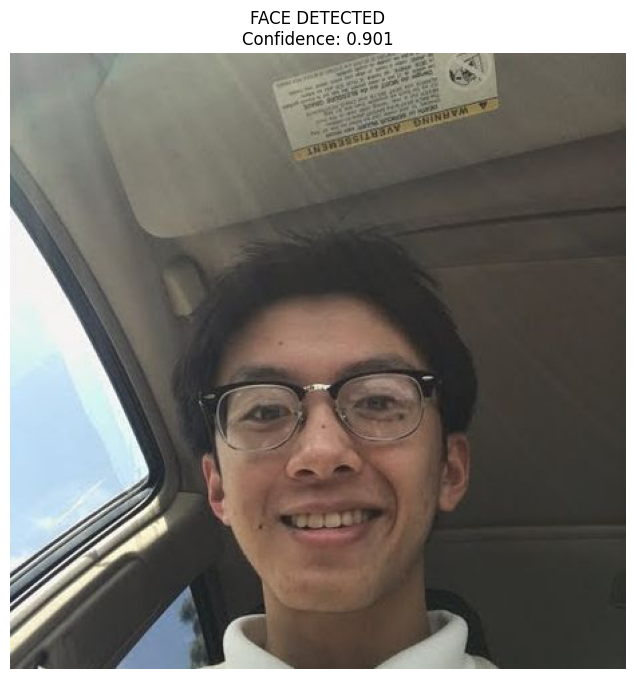


Detection Results:
Contains face: True
Confidence: 0.901


In [47]:
model_path = "improvedDDFD.pth"  
test_image_path = "ben.jpg" 

evaluate_image(model_path, test_image_path)

Using device: cuda


<ipython-input-44-a5fb9494fc75>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.device)


Model loaded successfully


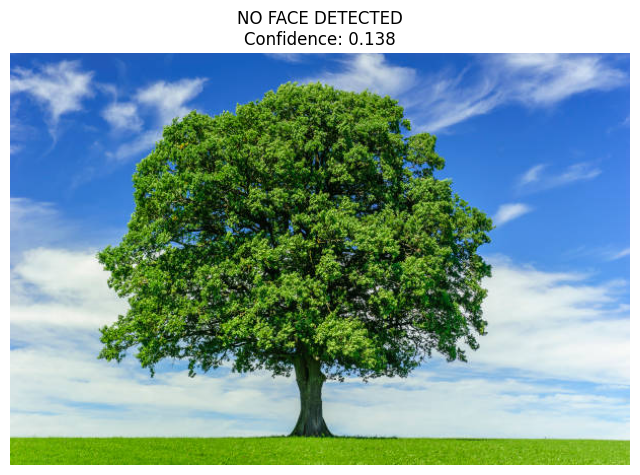


Detection Results:
Contains face: False
Confidence: 0.138


In [51]:
test_image_path = "tree.jpg"  # Path to test image

evaluate_image(model_path, test_image_path)